In [1]:
import tensorflow as tf
import numpy as np

from konlpy.tag import Twitter
import pandas as pd
import tensorflow as tf
import enum
import os
import re
import json
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

from preprocessor import *

2024-08-03 19:47:49.392479: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-03 19:47:49.641071: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-03 19:47:49.641110: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-03 19:47:49.682110: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-03 19:47:49.767936: I tensorflow/core/platform/cpu_feature_guar

# Graph visualization

In [2]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

# Load Data set

In [3]:
DATA_IN_PATH = './data_set/'
DATA_OUT_PATH = './data_out/'
TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIGS = 'data_configs.json'

In [4]:
index_inputs = np.load(open(DATA_IN_PATH + TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(DATA_IN_PATH + TRAIN_OUTPUTS , 'rb'))
index_targets = np.load(open(DATA_IN_PATH + TRAIN_TARGETS , 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

# Fix Random Seed

In [5]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

# Model Setting

In [6]:
char2idx = prepro_configs['char2idx']
end_index = prepro_configs['end_symbol']
model_name = 'transformer'
vocab_size = prepro_configs['vocab_size']
BATCH_SIZE = 2
MAX_SEQUENCE = 25
EPOCHS = 30
VALID_SPLIT = 0.1

In [7]:
char2idx

{'<PAD>': 0,
 '<SOS>': 1,
 '<END>': 2,
 '<UNK>': 3,
 '밤샜어': 4,
 '생각나네': 5,
 '잘자': 6,
 '밤이네요': 7,
 '세달': 8,
 '사로잡는': 9,
 '새벽': 10,
 '챙김받고': 11,
 '좋겠는': 12,
 '쇼핑했더니': 13,
 '붙잡아도': 14,
 '만들어줄까': 15,
 '울렸으면': 16,
 '냉정해진다': 17,
 '휘성노래가': 18,
 '톡을': 19,
 '아니지요': 20,
 '실행해보세요': 21,
 '걱정임': 22,
 '차였어': 23,
 '봐달라고': 24,
 '나른하다': 25,
 '이야기해주세요': 26,
 '휴반년이라는': 27,
 '3개월만에': 28,
 '듣고': 29,
 '결혼하재': 30,
 '쓴만큼': 31,
 '오려나': 32,
 '마지막으로': 33,
 '위험하네요': 34,
 '이상형뿐일': 35,
 '썼다가': 36,
 '기적같은': 37,
 '따르나봐요': 38,
 '양해를': 39,
 '않은거예요': 40,
 '허전하신가봐요': 41,
 '배웠길': 42,
 '한살': 43,
 '방금다녀와서': 44,
 '이사를': 45,
 '사람에게': 46,
 '첫만남': 47,
 '확인사살': 48,
 '정리해야할': 49,
 '책상': 50,
 '어릴땐': 51,
 '자격증': 52,
 '잔인했던가': 53,
 '미팅에서': 54,
 '울어버려요': 55,
 '통장': 56,
 '면접': 57,
 '욕은': 58,
 '잊혀질거라': 59,
 '바라는것도': 60,
 '빠졌나봐요': 61,
 '생각들이': 62,
 '없답니다': 63,
 '투자한': 64,
 '기억안': 65,
 '행복': 66,
 '야식': 67,
 '택배': 68,
 '답답하겠네요': 69,
 '거랑': 70,
 '답답한게': 71,
 '맞춰보는': 72,
 '귀찮게해': 73,
 '배울': 74,
 '생각': 75,
 '모른': 76,
 '멀리하세요': 77,
 '연속이예요': 

In [8]:
end_index

'<END>'

In [9]:
vocab_size

20705

In [10]:
kargs = {'model_name': model_name,
         'num_layers': 2,
         'd_model': 512,
         'num_heads': 8,
         'dff': 2048,
         'input_vocab_size': vocab_size,
         'target_vocab_size': vocab_size,
         'maximum_position_encoding': MAX_SEQUENCE,
         'end_token_idx': char2idx[end_index],
         'rate': 0.1
        }

# Padding & Forward-masking

In [11]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [12]:
def create_look_ahead_mask(size):
    # 마스킹할 영역을 1, 아닌 영역을 0으로 처리
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0) #(입력 행렬, -1, 0)
    return mask  # (seq_len, seq_len)

In [13]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [14]:
index_inputs

array([[11034,  4489,     0, ...,     0,     0,     0],
       [ 3278, 11766, 16612, ...,     0,     0,     0],
       [ 4584, 15569, 13314, ...,     0,     0,     0],
       ...,
       [ 1245,  4083, 19327, ...,     0,     0,     0],
       [17844, 11697,  8357, ...,     0,     0,     0],
       [ 9695, 12475,     0, ...,     0,     0,     0]], dtype=int32)

In [15]:
index_outputs

array([[    1, 10553,  2770, ...,     0,     0,     0],
       [    1, 11813, 10407, ...,     0,     0,     0],
       [    1, 10025, 12993, ...,     0,     0,     0],
       ...,
       [    1,  5504,     0, ...,     0,     0,     0],
       [    1, 11580,  8964, ...,     0,     0,     0],
       [    1, 17285,  2490, ...,     0,     0,     0]], dtype=int32)

In [16]:
enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(index_inputs, index_outputs)

2024-08-03 19:47:53.263201: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-03 19:47:53.402048: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-03 19:47:53.402098: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-03 19:47:53.404898: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-03 19:47:53.404936: I external/local_xla/xla/stream_executor

In [17]:
enc_padding_mask.shape

TensorShape([11823, 1, 1, 25])

In [18]:
look_ahead_mask.shape

TensorShape([11823, 1, 25, 25])

In [19]:
dec_padding_mask.shape

TensorShape([11823, 1, 1, 25])

# Positional Encoding

In [20]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * i//2) / np.float32(d_model))
    return pos * angle_rates

In [21]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    # np.newaxis : 새로운 차원을 만드는 역할
    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)
tf.Tensor(
[[ 0.00000000e+00  1.00000000e+00  0.00000000e+00 ...  1.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [ 8.41470957e-01  5.55217505e-01  8.21856201e-01 ...  1.00000000e+00
   1.03663289e-04  1.00000000e+00]
 [ 9.09297407e-01 -3.83467078e-01  9.36414719e-01 ...  1.00000000e+00
   2.07326579e-04  1.00000000e+00]
 ...
 [ 1.23573124e-01 -5.72035491e-01  9.77189839e-01 ...  9.99987721e-01
   4.87215538e-03  9.99988556e-01]
 [-7.68254638e-01 -9.99792695e-01  7.31235921e-01 ...  9.99987185e-01
   4.97581763e-03  9.99988079e-01]
 [-9.53752637e-01 -5.38169324e-01 -1.44026920e-01 ...  9.99986649e-01
   5.07947942e-03  9.99987543e-01]], shape=(50, 512), dtype=float32)


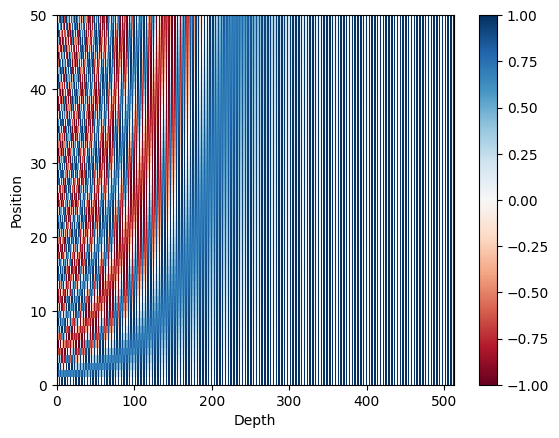

In [30]:
pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape)
print(pos_encoding[0])

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [23]:
pos_encoding

<tf.Tensor: shape=(1, 50, 512), dtype=float32, numpy=
array([[[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
          1.00000000e+00,  0.00000000e+00,  1.00000000e+00],
        [ 8.41470957e-01,  5.55217505e-01,  8.21856201e-01, ...,
          1.00000000e+00,  1.03663289e-04,  1.00000000e+00],
        [ 9.09297407e-01, -3.83467078e-01,  9.36414719e-01, ...,
          1.00000000e+00,  2.07326579e-04,  1.00000000e+00],
        ...,
        [ 1.23573124e-01, -5.72035491e-01,  9.77189839e-01, ...,
          9.99987721e-01,  4.87215538e-03,  9.99988556e-01],
        [-7.68254638e-01, -9.99792695e-01,  7.31235921e-01, ...,
          9.99987185e-01,  4.97581763e-03,  9.99988079e-01],
        [-9.53752637e-01, -5.38169324e-01, -1.44026920e-01, ...,
          9.99986649e-01,  5.07947942e-03,  9.99987543e-01]]],
      dtype=float32)>

# Attention

In [24]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead)
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

# Multi-head Attention

In [31]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = kargs['num_heads']
        self.d_model = kargs['d_model']

        assert self.d_model % self.num_heads == 0

        self.depth = self.d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(kargs['d_model'])
        self.wk = tf.keras.layers.Dense(kargs['d_model'])
        self.wv = tf.keras.layers.Dense(kargs['d_model'])

        self.dense = tf.keras.layers.Dense(kargs['d_model'])

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

# Position-wise Feedforward Network

In [26]:
def point_wise_feed_forward_network(**kargs):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(kargs['dff'], activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(kargs['d_model'])  # (batch_size, seq_len, d_model)
    ])

# Encoder Layer

In [32]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(**kargs)
        self.ffn = point_wise_feed_forward_network(**kargs)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout2 = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

# Decoder Layer

In [34]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(**kargs)
        self.mha2 = MultiHeadAttention(**kargs)

        self.ffn = point_wise_feed_forward_network(**kargs)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout2 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout3 = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, enc_output, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

# Encoder

In [36]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(Encoder, self).__init__()

        self.d_model = kargs['d_model']
        self.num_layers = kargs['num_layers']

        # 총 단어의 수 : kargs['input_vocab_size']
        # 임베딩 후 출력되는 크기 : self.d_model = 512
        self.embedding = tf.keras.layers.Embedding(kargs['input_vocab_size'], self.d_model)
        self.pos_encoding = positional_encoding(kargs['maximum_position_encoding'], self.d_model)

        self.enc_layers = [EncoderLayer(**kargs) for _ in range(self.num_layers)]

        self.dropout = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, mask):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)

        # 차원 수의 제곱근만큼에 대한 가중치를 곱
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, mask)

        return x  # (batch_size, input_seq_len, d_model)

# Decoder

In [37]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(Decoder, self).__init__()

        self.d_model = kargs['d_model']
        self.num_layers = kargs['num_layers']

        self.embedding = tf.keras.layers.Embedding(kargs['target_vocab_size'], self.d_model)
        self.pos_encoding = positional_encoding(kargs['maximum_position_encoding'], self.d_model)

        self.dec_layers = [DecoderLayer(**kargs) for _ in range(self.num_layers)]
        self.dropout = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, enc_output, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

# Transformer Model

In [38]:
class Transformer(tf.keras.Model):
    def __init__(self, **kargs):
        super(Transformer, self).__init__(name=kargs['model_name'])
        self.end_token_idx = kargs['end_token_idx']

        self.encoder = Encoder(**kargs)
        self.decoder = Decoder(**kargs)

        self.final_layer = tf.keras.layers.Dense(kargs['target_vocab_size'])

    def call(self, x):
        inp, tar = x

        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)
        enc_output = self.encoder(inp, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, _ = self.decoder(tar, enc_output, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output

    def inference(self, x):
        inp = x
        tar = tf.expand_dims([STD_INDEX], 0)

        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)
        enc_output = self.encoder(inp, enc_padding_mask)

        predict_tokens = list()
        for t in range(0, MAX_SEQUENCE):
            dec_output, _ = self.decoder(tar, enc_output, look_ahead_mask, dec_padding_mask)
            final_output = self.final_layer(dec_output)

            # tf.argmax : 가장 큰 값의 index를 return
            # -1은 마지막 축 ex. 2차원이면 axis=1 (행을 의미)
            outputs = tf.argmax(final_output, -1).numpy()
            pred_token = outputs[0][-1]
            if pred_token == self.end_token_idx:
                break
            predict_tokens.append(pred_token)
            tar = tf.expand_dims([STD_INDEX] + predict_tokens, 0)
            _, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)
        return predict_tokens

# Define Model Loss

In [39]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

def loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

def accuracy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask
    acc = train_accuracy(real, pred)

    return tf.reduce_mean(acc)

In [40]:
model = Transformer(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=loss, metrics=[accuracy])

# Define callback

In [42]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)

checkpoint_path = DATA_OUT_PATH + model_name + '/checkpoints.weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))


cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

./data_out/transformer -- Folder already exists 



In [51]:
history = model.fit([index_inputs, index_outputs], index_targets,
                    batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/30
5320/5320 [==============================] - ETA: 0s - loss: 0.3899 - accuracy: 0.8886
Epoch 1: val_accuracy improved from 0.88809 to 0.88914, saving model to ./data_out/transformer/checkpoints.weights.h5
5320/5320 [==============================] - 133s 25ms/step - loss: 0.3899 - accuracy: 0.8886 - val_loss: 1.9744 - val_accuracy: 0.8891
Epoch 2/30
5319/5320 [============================>.] - ETA: 0s - loss: 0.3874 - accuracy: 0.8897
Epoch 2: val_accuracy improved from 0.88914 to 0.89015, saving model to ./data_out/transformer/checkpoints.weights.h5
5320/5320 [==============================] - 138s 26ms/step - loss: 0.3874 - accuracy: 0.8897 - val_loss: 1.8883 - val_accuracy: 0.8902
Epoch 3/30
5319/5320 [============================>.] - ETA: 0s - loss: 0.3794 - accuracy: 0.8907
Epoch 3: val_accuracy improved from 0.89015 to 0.89115, saving model to ./data_out/transformer/checkpoints.weights.h5
5320/5320 [==============================] - 133s 25ms/step - loss: 0.3794 - acc

# Result

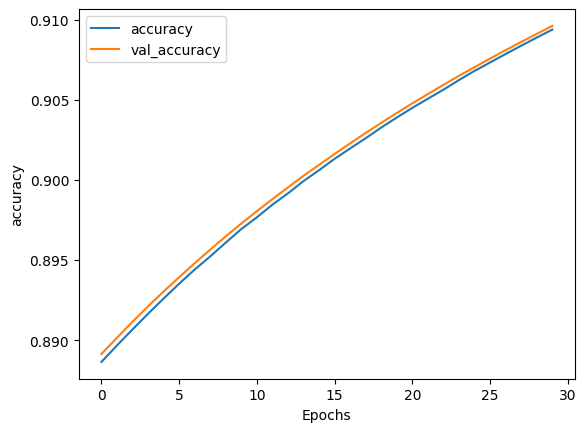

In [52]:
plot_graphs(history, 'accuracy')

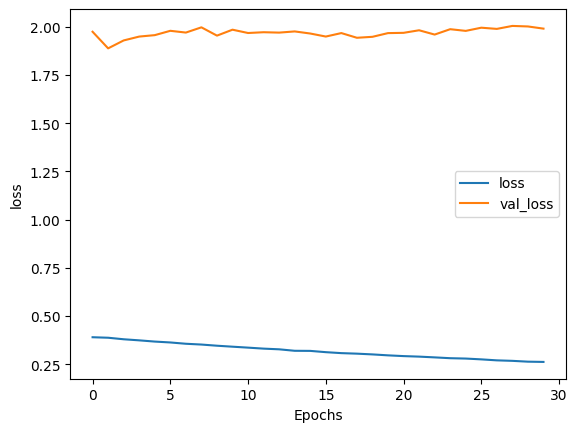

In [53]:
plot_graphs(history, 'loss')

# Load best model

In [60]:
DATA_OUT_PATH = './data_out/'
SAVE_FILE_NM = 'checkpoints.weights.h5'

model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [61]:
char2idx = prepro_configs['char2idx']
idx2char = prepro_configs['idx2char']

In [62]:
text = "남자친구 승진 선물로 뭐가 좋을까?"
test_index_inputs, _ = enc_processing([text], char2idx)
outputs = model.inference(test_index_inputs)

print(' '.join([idx2char[str(o)] for o in outputs]))

살짝 감정을 흘려보세요
